# WGAN Training

## imports

In [1]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.4
config.gpu_options.allow_growth=True
set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt

from models.WassersteinGenerativeAdversarialNetwork import WassersteinGenerativeAdversarialNetwork as WGAN
from utils.loaders import load_cifar



In [3]:
# run params
SECTION = 'wgan'
RUN_ID = '0002'
DATA_NAME = 'horses'
RUN_FOLDER = f'run/{SECTION}/'
RUN_FOLDER += f'{RUN_ID}_{DATA_NAME}'

for p in ['run', f'run/{SECTION}']:
    if not os.path.exists(p):
        os.mkdir(p)

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build' #'load' #


## data

In [4]:
if DATA_NAME == 'cars':
    label = 1
elif DATA_NAME == 'horses':
    label = 7
(x_train, y_train) = load_cifar(label, 10)


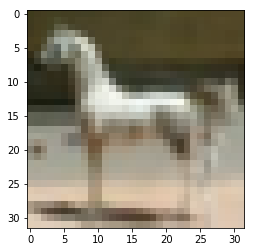

In [5]:
plt.imshow((x_train[150,:,:,:]+1)/2)

## architecture

In [6]:
image_dim = (32,32,3)
latent_dim = 100

generator_initial_dim = (4, 4, 128)

generator_activation = 'leaky_relu'
critic_activation = 'leaky_relu'

critic_learning_rate = 0.00005,
generator_learning_rate = 0.00005,
generator_batch_norm_momentum = 0.8
critic_batch_norm_momentum = None
critic_dense_dim = 0
generator_dropout_rate = None
critic_dropout_rate = None

generator_convolutional_params = [
    {'strides': (1, 1), 'filters': 128, 'kernel_size': (5, 5), 'upsample': 2, },
    {'strides': (1, 1), 'filters': 64, 'kernel_size': (5, 5), 'upsample': 2, },
    {'strides': (1, 1), 'filters': 32, 'kernel_size': (5, 5), 'upsample': 2, },
    {'strides': (1, 1), 'filters': 3, 'kernel_size': (5, 5), 'upsample': 1, },
    ]

critic_convolutional_params = [
    {'strides': (2, 2), 'filters': 32, 'kernel_size': (5, 5),},
    {'strides': (2, 2), 'filters': 64, 'kernel_size': (5, 5),},
    {'strides': (2, 2), 'filters': 128, 'kernel_size': (5, 5),},
    {'strides': (1, 1), 'filters': 128, 'kernel_size': (5, 5),},
    ]

In [7]:
if mode == 'build':
    gan = WGAN(
        image_dim=image_dim,
        latent_dim=latent_dim,
        generator_initial_dim=generator_initial_dim,
        critic_dense_dim=critic_dense_dim,
        generator_activation=generator_activation,
        critic_activation=critic_activation,
        generator_convolutional_params=generator_convolutional_params,
        critic_learning_rate = critic_learning_rate,
        generator_learning_rate = generator_learning_rate,
        critic_convolutional_params=critic_convolutional_params,
        generator_batch_norm_momentum=generator_batch_norm_momentum,
        critic_batch_norm_momentum=critic_batch_norm_momentum,
        generator_dropout_rate=generator_dropout_rate,
        critic_dropout_rate=critic_dropout_rate,
        )
    gan.save(RUN_FOLDER)

else:
    gan.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))








W0607 21:00:46.760274 140081132005120 deprecation.py:506] From /home/comadan/.venv/gdl/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [8]:
gan.critic_model.summary()

Model: "critic_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
critic_input (InputLayer)    (None, 32, 32, 3)         0         
_________________________________________________________________
critic_conv2d_0 (Conv2D)     (None, 16, 16, 32)        2432      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 32)        0         
_________________________________________________________________
critic_conv2d_1 (Conv2D)     (None, 8, 8, 64)          51264     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 64)          0         
_________________________________________________________________
critic_conv2d_2 (Conv2D)     (None, 4, 4, 128)         204928    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 4, 4, 128)        

In [9]:
gan.generator_model.summary()

Model: "generator_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_input (InputLayer) (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              206848    
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 2048)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 128)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 8, 8, 128)         0         
_________________________________________________________________
generator_conv2d_0 (Conv2D)  (None, 8, 8, 128)     

## training

In [10]:
BATCH_SIZE = 128
EPOCHS = 6000
PRINT_EVERY_N_BATCHES = 5
N_CRITIC = 5 # using double here, because book separates true and generated examples.
CLIP_THRESHOLD = 0.01

In [11]:
gan.train(     
    x_train
    , batch_size=BATCH_SIZE
    , epochs=EPOCHS
    , run_folder=RUN_FOLDER
    , print_every_n_batches=PRINT_EVERY_N_BATCHES
    , critic_training_steps=N_CRITIC
    , clip_threshold=CLIP_THRESHOLD
    , alternating_critic=True
)

W0607 21:00:48.486189 140081132005120 module_wrapper.py:139] From /home/comadan/.venv/gdl/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.

/home/comadan/.venv/gdl/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch: 0  disc. loss: (v: -0.000 g: 0.000) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.000 acc.: 0.000


/home/comadan/.venv/gdl/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch: 1  disc. loss: (v: -0.001 g: 0.000) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.001 acc.: 0.000
epoch: 2  disc. loss: (v: -0.004 g: 0.001) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.005 acc.: 0.000
epoch: 3  disc. loss: (v: -0.014 g: 0.003) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.020 acc.: 0.000
epoch: 4  disc. loss: (v: -0.040 g: 0.008) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.059 acc.: 0.000
epoch: 5  disc. loss: (v: -0.088 g: 0.019) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.143 acc.: 0.000
epoch: 6  disc. loss: (v: -0.194 g: 0.032) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.329 acc.: 0.000
epoch: 7  disc. loss: (v: -0.360 g: 0.054) acc.: (v: 0.109 g: 0.000)  gen. loss:-0.700 acc.: 0.922
epoch: 8  disc. loss: (v: -0.625 g: 0.059) acc.: (v: 0.703 g: 0.000)  gen. loss:-1.369 acc.: 0.664
epoch: 9  disc. loss: (v: -1.054 g: 0.077) acc.: (v: 0.844 g: 0.000)  gen. loss:-2.488 acc.: 0.016
epoch: 10  disc. loss: (v: -1.639 g: 0.136) acc.: (v: 0.453 g: 0.000)  gen. loss:-4.073 acc.: 0.000
epoch: 11

epoch: 84  disc. loss: (v: -3.005 g: 1.602) acc.: (v: 0.273 g: 0.016)  gen. loss:-0.265 acc.: 0.234
epoch: 85  disc. loss: (v: -3.020 g: 1.034) acc.: (v: 0.242 g: 0.070)  gen. loss:0.081 acc.: 0.148
epoch: 86  disc. loss: (v: -3.255 g: 0.726) acc.: (v: 0.258 g: 0.164)  gen. loss:0.208 acc.: 0.117
epoch: 87  disc. loss: (v: -4.024 g: 0.612) acc.: (v: 0.219 g: 0.242)  gen. loss:0.070 acc.: 0.164
epoch: 88  disc. loss: (v: -4.388 g: 1.150) acc.: (v: 0.172 g: 0.156)  gen. loss:-0.678 acc.: 0.219
epoch: 89  disc. loss: (v: -5.053 g: 2.647) acc.: (v: 0.148 g: 0.078)  gen. loss:-1.971 acc.: 0.188
epoch: 90  disc. loss: (v: -5.152 g: 4.400) acc.: (v: 0.109 g: 0.039)  gen. loss:-3.821 acc.: 0.102
epoch: 91  disc. loss: (v: -4.797 g: 6.192) acc.: (v: 0.195 g: 0.023)  gen. loss:-4.934 acc.: 0.078
epoch: 92  disc. loss: (v: -3.523 g: 6.510) acc.: (v: 0.211 g: 0.008)  gen. loss:-5.224 acc.: 0.094
epoch: 93  disc. loss: (v: -2.523 g: 5.096) acc.: (v: 0.273 g: 0.000)  gen. loss:-5.018 acc.: 0.062
epo

epoch: 166  disc. loss: (v: -2.238 g: 3.598) acc.: (v: 0.281 g: 0.000)  gen. loss:-2.873 acc.: 0.141
epoch: 167  disc. loss: (v: -1.725 g: 2.243) acc.: (v: 0.375 g: 0.000)  gen. loss:-1.945 acc.: 0.305
epoch: 168  disc. loss: (v: -1.755 g: 1.375) acc.: (v: 0.359 g: 0.000)  gen. loss:-1.215 acc.: 0.281
epoch: 169  disc. loss: (v: -1.506 g: 0.776) acc.: (v: 0.375 g: 0.047)  gen. loss:-0.520 acc.: 0.227
epoch: 170  disc. loss: (v: -1.095 g: 0.183) acc.: (v: 0.258 g: 0.156)  gen. loss:-0.108 acc.: 0.211
epoch: 171  disc. loss: (v: -1.502 g: 0.501) acc.: (v: 0.336 g: 0.125)  gen. loss:-0.244 acc.: 0.211
epoch: 172  disc. loss: (v: -1.724 g: 0.520) acc.: (v: 0.156 g: 0.117)  gen. loss:-0.443 acc.: 0.109
epoch: 173  disc. loss: (v: -1.738 g: 0.993) acc.: (v: 0.188 g: 0.070)  gen. loss:-1.210 acc.: 0.156
epoch: 174  disc. loss: (v: -1.877 g: 1.546) acc.: (v: 0.109 g: 0.023)  gen. loss:-2.054 acc.: 0.195
epoch: 175  disc. loss: (v: -2.140 g: 2.280) acc.: (v: 0.188 g: 0.016)  gen. loss:-2.451 ac

epoch: 248  disc. loss: (v: -0.180 g: 0.187) acc.: (v: 0.164 g: 0.062)  gen. loss:-0.134 acc.: 0.195
epoch: 249  disc. loss: (v: -0.193 g: 0.275) acc.: (v: 0.219 g: 0.109)  gen. loss:-0.127 acc.: 0.258
epoch: 250  disc. loss: (v: -0.144 g: 0.245) acc.: (v: 0.188 g: 0.078)  gen. loss:-0.151 acc.: 0.227
epoch: 251  disc. loss: (v: -0.025 g: 0.106) acc.: (v: 0.109 g: 0.086)  gen. loss:-0.112 acc.: 0.188
epoch: 252  disc. loss: (v: 0.007 g: 0.047) acc.: (v: 0.102 g: 0.141)  gen. loss:-0.045 acc.: 0.109
epoch: 253  disc. loss: (v: 0.048 g: -0.164) acc.: (v: 0.062 g: 0.234)  gen. loss:0.097 acc.: 0.086
epoch: 254  disc. loss: (v: 0.075 g: -0.110) acc.: (v: 0.078 g: 0.234)  gen. loss:0.149 acc.: 0.086
epoch: 255  disc. loss: (v: -0.013 g: -0.222) acc.: (v: 0.109 g: 0.305)  gen. loss:0.130 acc.: 0.078
epoch: 256  disc. loss: (v: 0.196 g: -0.154) acc.: (v: 0.070 g: 0.266)  gen. loss:0.134 acc.: 0.078
epoch: 257  disc. loss: (v: 0.166 g: 0.015) acc.: (v: 0.031 g: 0.109)  gen. loss:0.073 acc.: 0.

epoch: 330  disc. loss: (v: -0.146 g: 0.112) acc.: (v: 0.078 g: 0.016)  gen. loss:-0.103 acc.: 0.031
epoch: 331  disc. loss: (v: -0.179 g: 0.144) acc.: (v: 0.133 g: 0.000)  gen. loss:-0.163 acc.: 0.086
epoch: 332  disc. loss: (v: -0.229 g: 0.184) acc.: (v: 0.117 g: 0.000)  gen. loss:-0.191 acc.: 0.062
epoch: 333  disc. loss: (v: -0.225 g: 0.189) acc.: (v: 0.078 g: 0.000)  gen. loss:-0.214 acc.: 0.062
epoch: 334  disc. loss: (v: -0.243 g: 0.231) acc.: (v: 0.117 g: 0.000)  gen. loss:-0.222 acc.: 0.086
epoch: 335  disc. loss: (v: -0.206 g: 0.247) acc.: (v: 0.078 g: 0.000)  gen. loss:-0.254 acc.: 0.039
epoch: 336  disc. loss: (v: -0.252 g: 0.248) acc.: (v: 0.102 g: 0.000)  gen. loss:-0.255 acc.: 0.055
epoch: 337  disc. loss: (v: -0.227 g: 0.294) acc.: (v: 0.055 g: 0.000)  gen. loss:-0.256 acc.: 0.055
epoch: 338  disc. loss: (v: -0.229 g: 0.323) acc.: (v: 0.055 g: 0.000)  gen. loss:-0.242 acc.: 0.023
epoch: 339  disc. loss: (v: -0.192 g: 0.290) acc.: (v: 0.023 g: 0.000)  gen. loss:-0.218 ac

epoch: 412  disc. loss: (v: -0.036 g: 0.008) acc.: (v: 0.000 g: 0.000)  gen. loss:0.018 acc.: 0.000
epoch: 413  disc. loss: (v: -0.032 g: 0.009) acc.: (v: 0.000 g: 0.000)  gen. loss:0.020 acc.: 0.000
epoch: 414  disc. loss: (v: -0.042 g: 0.011) acc.: (v: 0.000 g: 0.000)  gen. loss:0.016 acc.: 0.000
epoch: 415  disc. loss: (v: -0.049 g: 0.020) acc.: (v: 0.000 g: 0.000)  gen. loss:0.019 acc.: 0.000
epoch: 416  disc. loss: (v: -0.047 g: 0.013) acc.: (v: 0.000 g: 0.000)  gen. loss:0.029 acc.: 0.000
epoch: 417  disc. loss: (v: -0.057 g: -0.001) acc.: (v: 0.000 g: 0.000)  gen. loss:0.030 acc.: 0.000
epoch: 418  disc. loss: (v: -0.056 g: 0.001) acc.: (v: 0.000 g: 0.000)  gen. loss:0.027 acc.: 0.000
epoch: 419  disc. loss: (v: -0.037 g: 0.028) acc.: (v: 0.000 g: 0.000)  gen. loss:0.003 acc.: 0.000
epoch: 420  disc. loss: (v: -0.059 g: 0.052) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.023 acc.: 0.000
epoch: 421  disc. loss: (v: -0.064 g: 0.071) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.039 acc.: 0.0

epoch: 494  disc. loss: (v: -0.017 g: -0.007) acc.: (v: 0.000 g: 0.000)  gen. loss:0.019 acc.: 0.000
epoch: 495  disc. loss: (v: -0.020 g: -0.008) acc.: (v: 0.000 g: 0.000)  gen. loss:0.015 acc.: 0.000
epoch: 496  disc. loss: (v: -0.034 g: 0.011) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.002 acc.: 0.000
epoch: 497  disc. loss: (v: -0.043 g: 0.035) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.034 acc.: 0.000
epoch: 498  disc. loss: (v: -0.050 g: 0.054) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.056 acc.: 0.000
epoch: 499  disc. loss: (v: -0.053 g: 0.069) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.053 acc.: 0.000
epoch: 500  disc. loss: (v: -0.048 g: 0.054) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.051 acc.: 0.000
epoch: 501  disc. loss: (v: -0.043 g: 0.059) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.038 acc.: 0.000
epoch: 502  disc. loss: (v: -0.041 g: 0.035) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.032 acc.: 0.000
epoch: 503  disc. loss: (v: -0.034 g: 0.036) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.027 ac

epoch: 576  disc. loss: (v: -0.048 g: 0.040) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.018 acc.: 0.000
epoch: 577  disc. loss: (v: -0.047 g: 0.032) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.010 acc.: 0.000
epoch: 578  disc. loss: (v: -0.036 g: 0.017) acc.: (v: 0.000 g: 0.000)  gen. loss:0.004 acc.: 0.000
epoch: 579  disc. loss: (v: -0.034 g: 0.012) acc.: (v: 0.000 g: 0.000)  gen. loss:0.012 acc.: 0.000
epoch: 580  disc. loss: (v: -0.024 g: -0.005) acc.: (v: 0.000 g: 0.000)  gen. loss:0.028 acc.: 0.000
epoch: 581  disc. loss: (v: -0.030 g: 0.000) acc.: (v: 0.000 g: 0.000)  gen. loss:0.028 acc.: 0.000
epoch: 582  disc. loss: (v: -0.041 g: 0.010) acc.: (v: 0.000 g: 0.000)  gen. loss:0.016 acc.: 0.000
epoch: 583  disc. loss: (v: -0.059 g: 0.022) acc.: (v: 0.000 g: 0.000)  gen. loss:0.005 acc.: 0.000
epoch: 584  disc. loss: (v: -0.059 g: 0.039) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.005 acc.: 0.000
epoch: 585  disc. loss: (v: -0.066 g: 0.046) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.020 acc.: 0

epoch: 658  disc. loss: (v: -0.047 g: 0.036) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.023 acc.: 0.000
epoch: 659  disc. loss: (v: -0.052 g: 0.036) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.024 acc.: 0.000
epoch: 660  disc. loss: (v: -0.055 g: 0.036) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.023 acc.: 0.000
epoch: 661  disc. loss: (v: -0.056 g: 0.045) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.029 acc.: 0.000
epoch: 662  disc. loss: (v: -0.053 g: 0.042) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.030 acc.: 0.000
epoch: 663  disc. loss: (v: -0.049 g: 0.044) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.026 acc.: 0.000
epoch: 664  disc. loss: (v: -0.048 g: 0.044) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.029 acc.: 0.000
epoch: 665  disc. loss: (v: -0.051 g: 0.045) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.027 acc.: 0.000
epoch: 666  disc. loss: (v: -0.045 g: 0.045) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.029 acc.: 0.000
epoch: 667  disc. loss: (v: -0.043 g: 0.041) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.028 ac

epoch: 740  disc. loss: (v: -0.050 g: 0.040) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.024 acc.: 0.000
epoch: 741  disc. loss: (v: -0.044 g: 0.044) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.031 acc.: 0.000
epoch: 742  disc. loss: (v: -0.048 g: 0.044) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.032 acc.: 0.000
epoch: 743  disc. loss: (v: -0.050 g: 0.044) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.025 acc.: 0.000
epoch: 744  disc. loss: (v: -0.048 g: 0.036) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.025 acc.: 0.000
epoch: 745  disc. loss: (v: -0.045 g: 0.039) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.028 acc.: 0.000
epoch: 746  disc. loss: (v: -0.055 g: 0.036) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.028 acc.: 0.000
epoch: 747  disc. loss: (v: -0.052 g: 0.034) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.022 acc.: 0.000
epoch: 748  disc. loss: (v: -0.054 g: 0.043) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.026 acc.: 0.000
epoch: 749  disc. loss: (v: -0.054 g: 0.040) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.027 ac

epoch: 822  disc. loss: (v: -0.055 g: 0.031) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.024 acc.: 0.000
epoch: 823  disc. loss: (v: -0.058 g: 0.030) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.012 acc.: 0.000
epoch: 824  disc. loss: (v: -0.057 g: 0.032) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.020 acc.: 0.000
epoch: 825  disc. loss: (v: -0.057 g: 0.028) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.014 acc.: 0.000
epoch: 826  disc. loss: (v: -0.063 g: 0.028) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.015 acc.: 0.000
epoch: 827  disc. loss: (v: -0.059 g: 0.038) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.022 acc.: 0.000
epoch: 828  disc. loss: (v: -0.064 g: 0.036) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.022 acc.: 0.000
epoch: 829  disc. loss: (v: -0.058 g: 0.027) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.018 acc.: 0.000
epoch: 830  disc. loss: (v: -0.055 g: 0.029) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.015 acc.: 0.000
epoch: 831  disc. loss: (v: -0.052 g: 0.023) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.018 ac

epoch: 904  disc. loss: (v: -0.097 g: 0.058) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.043 acc.: 0.000
epoch: 905  disc. loss: (v: -0.103 g: 0.066) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.046 acc.: 0.000
epoch: 906  disc. loss: (v: -0.127 g: 0.084) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.067 acc.: 0.000
epoch: 907  disc. loss: (v: -0.131 g: 0.106) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.095 acc.: 0.000
epoch: 908  disc. loss: (v: -0.132 g: 0.111) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.101 acc.: 0.000
epoch: 909  disc. loss: (v: -0.116 g: 0.104) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.094 acc.: 0.000
epoch: 910  disc. loss: (v: -0.119 g: 0.082) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.089 acc.: 0.000
epoch: 911  disc. loss: (v: -0.112 g: 0.087) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.081 acc.: 0.000
epoch: 912  disc. loss: (v: -0.106 g: 0.079) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.059 acc.: 0.000
epoch: 913  disc. loss: (v: -0.103 g: 0.068) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.057 ac

epoch: 986  disc. loss: (v: -0.097 g: 0.069) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.039 acc.: 0.000
epoch: 987  disc. loss: (v: -0.122 g: 0.096) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.057 acc.: 0.000
epoch: 988  disc. loss: (v: -0.129 g: 0.085) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.061 acc.: 0.000
epoch: 989  disc. loss: (v: -0.114 g: 0.086) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.052 acc.: 0.000
epoch: 990  disc. loss: (v: -0.123 g: 0.093) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.071 acc.: 0.000
epoch: 991  disc. loss: (v: -0.110 g: 0.093) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.064 acc.: 0.000
epoch: 992  disc. loss: (v: -0.103 g: 0.080) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.058 acc.: 0.000
epoch: 993  disc. loss: (v: -0.083 g: 0.077) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.047 acc.: 0.000
epoch: 994  disc. loss: (v: -0.083 g: 0.065) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.044 acc.: 0.000
epoch: 995  disc. loss: (v: -0.081 g: 0.060) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.041 ac

epoch: 1067  disc. loss: (v: -0.073 g: 0.038) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.029 acc.: 0.000
epoch: 1068  disc. loss: (v: -0.063 g: 0.034) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.022 acc.: 0.000
epoch: 1069  disc. loss: (v: -0.057 g: 0.039) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.017 acc.: 0.000
epoch: 1070  disc. loss: (v: -0.055 g: 0.027) acc.: (v: 0.000 g: 0.000)  gen. loss:0.001 acc.: 0.000
epoch: 1071  disc. loss: (v: -0.049 g: 0.013) acc.: (v: 0.000 g: 0.000)  gen. loss:0.002 acc.: 0.000
epoch: 1072  disc. loss: (v: -0.063 g: 0.046) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.022 acc.: 0.000
epoch: 1073  disc. loss: (v: -0.060 g: 0.043) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.013 acc.: 0.000
epoch: 1074  disc. loss: (v: -0.070 g: 0.049) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.023 acc.: 0.000
epoch: 1075  disc. loss: (v: -0.075 g: 0.048) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.028 acc.: 0.000
epoch: 1076  disc. loss: (v: -0.061 g: 0.043) acc.: (v: 0.000 g: 0.000)  gen. loss:-

epoch: 1148  disc. loss: (v: -0.041 g: 0.013) acc.: (v: 0.000 g: 0.000)  gen. loss:0.005 acc.: 0.000
epoch: 1149  disc. loss: (v: -0.051 g: 0.011) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.005 acc.: 0.000
epoch: 1150  disc. loss: (v: -0.056 g: 0.005) acc.: (v: 0.000 g: 0.000)  gen. loss:0.005 acc.: 0.000
epoch: 1151  disc. loss: (v: -0.058 g: 0.039) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.014 acc.: 0.000
epoch: 1152  disc. loss: (v: -0.054 g: 0.039) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.023 acc.: 0.000
epoch: 1153  disc. loss: (v: -0.073 g: 0.036) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.010 acc.: 0.000
epoch: 1154  disc. loss: (v: -0.057 g: 0.054) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.022 acc.: 0.000
epoch: 1155  disc. loss: (v: -0.070 g: 0.048) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.021 acc.: 0.000
epoch: 1156  disc. loss: (v: -0.057 g: 0.031) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.013 acc.: 0.000
epoch: 1157  disc. loss: (v: -0.064 g: 0.056) acc.: (v: 0.000 g: 0.000)  gen. loss:-

epoch: 1229  disc. loss: (v: -0.074 g: 0.036) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.019 acc.: 0.000
epoch: 1230  disc. loss: (v: -0.063 g: 0.039) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.012 acc.: 0.000
epoch: 1231  disc. loss: (v: -0.076 g: 0.039) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.014 acc.: 0.000
epoch: 1232  disc. loss: (v: -0.072 g: 0.056) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.030 acc.: 0.000
epoch: 1233  disc. loss: (v: -0.069 g: 0.033) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.013 acc.: 0.000
epoch: 1234  disc. loss: (v: -0.069 g: 0.032) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.021 acc.: 0.000
epoch: 1235  disc. loss: (v: -0.073 g: 0.041) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.027 acc.: 0.000
epoch: 1236  disc. loss: (v: -0.072 g: 0.039) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.025 acc.: 0.000
epoch: 1237  disc. loss: (v: -0.068 g: 0.059) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.037 acc.: 0.000
epoch: 1238  disc. loss: (v: -0.066 g: 0.042) acc.: (v: 0.000 g: 0.000)  gen. loss

epoch: 1310  disc. loss: (v: -0.083 g: 0.064) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.033 acc.: 0.000
epoch: 1311  disc. loss: (v: -0.078 g: 0.046) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.022 acc.: 0.000
epoch: 1312  disc. loss: (v: -0.072 g: 0.049) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.029 acc.: 0.000
epoch: 1313  disc. loss: (v: -0.070 g: 0.052) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.028 acc.: 0.000
epoch: 1314  disc. loss: (v: -0.077 g: 0.048) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.016 acc.: 0.000
epoch: 1315  disc. loss: (v: -0.077 g: 0.037) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.018 acc.: 0.000
epoch: 1316  disc. loss: (v: -0.067 g: 0.034) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.016 acc.: 0.000
epoch: 1317  disc. loss: (v: -0.076 g: 0.038) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.020 acc.: 0.000
epoch: 1318  disc. loss: (v: -0.062 g: 0.038) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.023 acc.: 0.000
epoch: 1319  disc. loss: (v: -0.069 g: 0.041) acc.: (v: 0.000 g: 0.000)  gen. loss

epoch: 1391  disc. loss: (v: -0.092 g: 0.074) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.056 acc.: 0.000
epoch: 1392  disc. loss: (v: -0.090 g: 0.065) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.046 acc.: 0.000
epoch: 1393  disc. loss: (v: -0.084 g: 0.062) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.037 acc.: 0.000
epoch: 1394  disc. loss: (v: -0.074 g: 0.051) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.031 acc.: 0.000
epoch: 1395  disc. loss: (v: -0.075 g: 0.044) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.021 acc.: 0.000
epoch: 1396  disc. loss: (v: -0.063 g: 0.027) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.008 acc.: 0.000
epoch: 1397  disc. loss: (v: -0.061 g: 0.043) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.018 acc.: 0.000
epoch: 1398  disc. loss: (v: -0.067 g: 0.031) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.008 acc.: 0.000
epoch: 1399  disc. loss: (v: -0.075 g: 0.052) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.032 acc.: 0.000
epoch: 1400  disc. loss: (v: -0.063 g: 0.039) acc.: (v: 0.000 g: 0.000)  gen. loss

epoch: 1472  disc. loss: (v: -0.064 g: 0.029) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.028 acc.: 0.000
epoch: 1473  disc. loss: (v: -0.072 g: 0.037) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.026 acc.: 0.000
epoch: 1474  disc. loss: (v: -0.064 g: 0.053) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.033 acc.: 0.000
epoch: 1475  disc. loss: (v: -0.078 g: 0.053) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.025 acc.: 0.000
epoch: 1476  disc. loss: (v: -0.073 g: 0.044) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.009 acc.: 0.000
epoch: 1477  disc. loss: (v: -0.072 g: 0.028) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.024 acc.: 0.000
epoch: 1478  disc. loss: (v: -0.062 g: 0.045) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.029 acc.: 0.000
epoch: 1479  disc. loss: (v: -0.071 g: 0.045) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.016 acc.: 0.000
epoch: 1480  disc. loss: (v: -0.070 g: 0.050) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.023 acc.: 0.000
epoch: 1481  disc. loss: (v: -0.073 g: 0.045) acc.: (v: 0.000 g: 0.000)  gen. loss

epoch: 1553  disc. loss: (v: -0.053 g: 0.024) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.008 acc.: 0.000
epoch: 1554  disc. loss: (v: -0.045 g: 0.028) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.006 acc.: 0.000
epoch: 1555  disc. loss: (v: -0.050 g: 0.029) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.008 acc.: 0.000
epoch: 1556  disc. loss: (v: -0.046 g: 0.028) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.009 acc.: 0.000
epoch: 1557  disc. loss: (v: -0.048 g: 0.027) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.004 acc.: 0.000
epoch: 1558  disc. loss: (v: -0.068 g: 0.022) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.005 acc.: 0.000
epoch: 1559  disc. loss: (v: -0.063 g: 0.027) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.010 acc.: 0.000
epoch: 1560  disc. loss: (v: -0.052 g: 0.023) acc.: (v: 0.000 g: 0.000)  gen. loss:0.001 acc.: 0.000
epoch: 1561  disc. loss: (v: -0.047 g: 0.019) acc.: (v: 0.000 g: 0.000)  gen. loss:0.005 acc.: 0.000
epoch: 1562  disc. loss: (v: -0.048 g: 0.017) acc.: (v: 0.000 g: 0.000)  gen. loss:0

epoch: 1634  disc. loss: (v: -0.059 g: 0.037) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.010 acc.: 0.000
epoch: 1635  disc. loss: (v: -0.068 g: 0.035) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.019 acc.: 0.000
epoch: 1636  disc. loss: (v: -0.065 g: 0.026) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.009 acc.: 0.000
epoch: 1637  disc. loss: (v: -0.071 g: 0.037) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.019 acc.: 0.000
epoch: 1638  disc. loss: (v: -0.080 g: 0.053) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.026 acc.: 0.000
epoch: 1639  disc. loss: (v: -0.074 g: 0.036) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.011 acc.: 0.000
epoch: 1640  disc. loss: (v: -0.068 g: 0.034) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.008 acc.: 0.000
epoch: 1641  disc. loss: (v: -0.086 g: 0.020) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.023 acc.: 0.000
epoch: 1642  disc. loss: (v: -0.072 g: 0.044) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.024 acc.: 0.000
epoch: 1643  disc. loss: (v: -0.070 g: 0.031) acc.: (v: 0.000 g: 0.000)  gen. loss

epoch: 1715  disc. loss: (v: -0.037 g: 0.016) acc.: (v: 0.000 g: 0.000)  gen. loss:0.003 acc.: 0.000
epoch: 1716  disc. loss: (v: -0.039 g: 0.015) acc.: (v: 0.000 g: 0.000)  gen. loss:0.005 acc.: 0.000
epoch: 1717  disc. loss: (v: -0.048 g: 0.002) acc.: (v: 0.000 g: 0.000)  gen. loss:0.020 acc.: 0.000
epoch: 1718  disc. loss: (v: -0.047 g: 0.028) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.005 acc.: 0.000
epoch: 1719  disc. loss: (v: -0.061 g: 0.024) acc.: (v: 0.000 g: 0.000)  gen. loss:0.000 acc.: 0.000
epoch: 1720  disc. loss: (v: -0.055 g: 0.016) acc.: (v: 0.000 g: 0.000)  gen. loss:0.015 acc.: 0.000
epoch: 1721  disc. loss: (v: -0.049 g: 0.023) acc.: (v: 0.000 g: 0.000)  gen. loss:0.005 acc.: 0.000
epoch: 1722  disc. loss: (v: -0.042 g: 0.018) acc.: (v: 0.000 g: 0.000)  gen. loss:0.007 acc.: 0.000
epoch: 1723  disc. loss: (v: -0.053 g: 0.017) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.000 acc.: 0.000
epoch: 1724  disc. loss: (v: -0.054 g: 0.019) acc.: (v: 0.000 g: 0.000)  gen. loss:0.001 

epoch: 1796  disc. loss: (v: -0.041 g: 0.016) acc.: (v: 0.000 g: 0.000)  gen. loss:0.005 acc.: 0.000
epoch: 1797  disc. loss: (v: -0.049 g: 0.018) acc.: (v: 0.000 g: 0.000)  gen. loss:0.002 acc.: 0.000
epoch: 1798  disc. loss: (v: -0.051 g: 0.009) acc.: (v: 0.000 g: 0.000)  gen. loss:0.010 acc.: 0.000
epoch: 1799  disc. loss: (v: -0.049 g: 0.024) acc.: (v: 0.000 g: 0.000)  gen. loss:0.004 acc.: 0.000
epoch: 1800  disc. loss: (v: -0.051 g: 0.015) acc.: (v: 0.000 g: 0.000)  gen. loss:0.005 acc.: 0.000
epoch: 1801  disc. loss: (v: -0.056 g: 0.003) acc.: (v: 0.000 g: 0.000)  gen. loss:0.002 acc.: 0.000
epoch: 1802  disc. loss: (v: -0.058 g: 0.024) acc.: (v: 0.000 g: 0.000)  gen. loss:0.003 acc.: 0.000
epoch: 1803  disc. loss: (v: -0.043 g: 0.008) acc.: (v: 0.000 g: 0.000)  gen. loss:0.006 acc.: 0.000
epoch: 1804  disc. loss: (v: -0.038 g: 0.015) acc.: (v: 0.000 g: 0.000)  gen. loss:0.002 acc.: 0.000
epoch: 1805  disc. loss: (v: -0.039 g: 0.009) acc.: (v: 0.000 g: 0.000)  gen. loss:0.010 ac

epoch: 1877  disc. loss: (v: -0.059 g: 0.017) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.004 acc.: 0.000
epoch: 1878  disc. loss: (v: -0.062 g: 0.037) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.020 acc.: 0.000
epoch: 1879  disc. loss: (v: -0.070 g: 0.034) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.015 acc.: 0.000
epoch: 1880  disc. loss: (v: -0.074 g: 0.040) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.020 acc.: 0.000
epoch: 1881  disc. loss: (v: -0.077 g: 0.034) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.008 acc.: 0.000
epoch: 1882  disc. loss: (v: -0.077 g: 0.041) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.016 acc.: 0.000
epoch: 1883  disc. loss: (v: -0.064 g: 0.037) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.011 acc.: 0.000
epoch: 1884  disc. loss: (v: -0.066 g: 0.026) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.010 acc.: 0.000
epoch: 1885  disc. loss: (v: -0.057 g: 0.043) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.004 acc.: 0.000
epoch: 1886  disc. loss: (v: -0.065 g: 0.032) acc.: (v: 0.000 g: 0.000)  gen. loss

epoch: 1958  disc. loss: (v: -0.056 g: 0.009) acc.: (v: 0.000 g: 0.000)  gen. loss:0.015 acc.: 0.000
epoch: 1959  disc. loss: (v: -0.046 g: 0.014) acc.: (v: 0.000 g: 0.000)  gen. loss:0.005 acc.: 0.000
epoch: 1960  disc. loss: (v: -0.048 g: 0.011) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.000 acc.: 0.000
epoch: 1961  disc. loss: (v: -0.044 g: 0.020) acc.: (v: 0.000 g: 0.000)  gen. loss:0.013 acc.: 0.000
epoch: 1962  disc. loss: (v: -0.052 g: 0.007) acc.: (v: 0.000 g: 0.000)  gen. loss:0.010 acc.: 0.000
epoch: 1963  disc. loss: (v: -0.044 g: 0.023) acc.: (v: 0.000 g: 0.000)  gen. loss:0.004 acc.: 0.000
epoch: 1964  disc. loss: (v: -0.052 g: 0.016) acc.: (v: 0.000 g: 0.000)  gen. loss:0.003 acc.: 0.000
epoch: 1965  disc. loss: (v: -0.063 g: 0.014) acc.: (v: 0.000 g: 0.000)  gen. loss:0.006 acc.: 0.000
epoch: 1966  disc. loss: (v: -0.048 g: -0.005) acc.: (v: 0.000 g: 0.000)  gen. loss:0.006 acc.: 0.000
epoch: 1967  disc. loss: (v: -0.042 g: 0.012) acc.: (v: 0.000 g: 0.000)  gen. loss:0.004 

epoch: 2039  disc. loss: (v: -0.045 g: 0.019) acc.: (v: 0.000 g: 0.000)  gen. loss:0.010 acc.: 0.000
epoch: 2040  disc. loss: (v: -0.054 g: 0.015) acc.: (v: 0.000 g: 0.000)  gen. loss:0.000 acc.: 0.000
epoch: 2041  disc. loss: (v: -0.051 g: 0.012) acc.: (v: 0.000 g: 0.000)  gen. loss:0.015 acc.: 0.000
epoch: 2042  disc. loss: (v: -0.045 g: 0.010) acc.: (v: 0.000 g: 0.000)  gen. loss:0.009 acc.: 0.000
epoch: 2043  disc. loss: (v: -0.058 g: 0.011) acc.: (v: 0.000 g: 0.000)  gen. loss:0.016 acc.: 0.000
epoch: 2044  disc. loss: (v: -0.059 g: 0.020) acc.: (v: 0.000 g: 0.000)  gen. loss:0.008 acc.: 0.000
epoch: 2045  disc. loss: (v: -0.055 g: 0.029) acc.: (v: 0.000 g: 0.000)  gen. loss:0.001 acc.: 0.000
epoch: 2046  disc. loss: (v: -0.057 g: 0.013) acc.: (v: 0.000 g: 0.000)  gen. loss:0.015 acc.: 0.000
epoch: 2047  disc. loss: (v: -0.048 g: 0.027) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.003 acc.: 0.000
epoch: 2048  disc. loss: (v: -0.049 g: 0.017) acc.: (v: 0.000 g: 0.000)  gen. loss:0.007 a

epoch: 2120  disc. loss: (v: -0.091 g: 0.036) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.026 acc.: 0.000
epoch: 2121  disc. loss: (v: -0.067 g: 0.031) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.004 acc.: 0.000
epoch: 2122  disc. loss: (v: -0.064 g: 0.030) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.009 acc.: 0.000
epoch: 2123  disc. loss: (v: -0.057 g: 0.037) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.009 acc.: 0.000
epoch: 2124  disc. loss: (v: -0.072 g: 0.025) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.006 acc.: 0.000
epoch: 2125  disc. loss: (v: -0.068 g: 0.029) acc.: (v: 0.000 g: 0.000)  gen. loss:0.001 acc.: 0.000
epoch: 2126  disc. loss: (v: -0.062 g: 0.029) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.002 acc.: 0.000
epoch: 2127  disc. loss: (v: -0.072 g: 0.013) acc.: (v: 0.000 g: 0.000)  gen. loss:0.005 acc.: 0.000
epoch: 2128  disc. loss: (v: -0.055 g: 0.013) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.008 acc.: 0.000
epoch: 2129  disc. loss: (v: -0.059 g: 0.005) acc.: (v: 0.000 g: 0.000)  gen. loss:-

epoch: 2201  disc. loss: (v: -0.065 g: 0.037) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.001 acc.: 0.000
epoch: 2202  disc. loss: (v: -0.061 g: 0.029) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.011 acc.: 0.000
epoch: 2203  disc. loss: (v: -0.074 g: 0.035) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.009 acc.: 0.000
epoch: 2204  disc. loss: (v: -0.064 g: 0.029) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.009 acc.: 0.000
epoch: 2205  disc. loss: (v: -0.072 g: 0.030) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.013 acc.: 0.000
epoch: 2206  disc. loss: (v: -0.075 g: 0.041) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.017 acc.: 0.000
epoch: 2207  disc. loss: (v: -0.069 g: 0.030) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.026 acc.: 0.000
epoch: 2208  disc. loss: (v: -0.057 g: 0.023) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.013 acc.: 0.000
epoch: 2209  disc. loss: (v: -0.057 g: 0.020) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.005 acc.: 0.000
epoch: 2210  disc. loss: (v: -0.054 g: 0.020) acc.: (v: 0.000 g: 0.000)  gen. loss

epoch: 2282  disc. loss: (v: -0.053 g: 0.026) acc.: (v: 0.000 g: 0.000)  gen. loss:0.001 acc.: 0.000
epoch: 2283  disc. loss: (v: -0.046 g: 0.022) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.006 acc.: 0.000
epoch: 2284  disc. loss: (v: -0.069 g: 0.027) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.010 acc.: 0.000
epoch: 2285  disc. loss: (v: -0.063 g: 0.043) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.012 acc.: 0.000
epoch: 2286  disc. loss: (v: -0.070 g: 0.025) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.015 acc.: 0.000
epoch: 2287  disc. loss: (v: -0.062 g: 0.026) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.002 acc.: 0.000
epoch: 2288  disc. loss: (v: -0.061 g: 0.020) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.014 acc.: 0.000
epoch: 2289  disc. loss: (v: -0.074 g: 0.026) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.015 acc.: 0.000
epoch: 2290  disc. loss: (v: -0.057 g: 0.032) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.007 acc.: 0.000
epoch: 2291  disc. loss: (v: -0.073 g: 0.047) acc.: (v: 0.000 g: 0.000)  gen. loss:

epoch: 2363  disc. loss: (v: -0.063 g: 0.029) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.005 acc.: 0.000
epoch: 2364  disc. loss: (v: -0.071 g: 0.032) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.010 acc.: 0.000
epoch: 2365  disc. loss: (v: -0.070 g: 0.035) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.005 acc.: 0.000
epoch: 2366  disc. loss: (v: -0.066 g: 0.020) acc.: (v: 0.000 g: 0.000)  gen. loss:0.003 acc.: 0.000
epoch: 2367  disc. loss: (v: -0.064 g: 0.030) acc.: (v: 0.000 g: 0.000)  gen. loss:0.004 acc.: 0.000
epoch: 2368  disc. loss: (v: -0.052 g: 0.027) acc.: (v: 0.000 g: 0.000)  gen. loss:0.002 acc.: 0.000
epoch: 2369  disc. loss: (v: -0.043 g: 0.018) acc.: (v: 0.000 g: 0.000)  gen. loss:0.002 acc.: 0.000
epoch: 2370  disc. loss: (v: -0.053 g: 0.023) acc.: (v: 0.000 g: 0.000)  gen. loss:0.002 acc.: 0.000
epoch: 2371  disc. loss: (v: -0.040 g: 0.035) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.003 acc.: 0.000
epoch: 2372  disc. loss: (v: -0.051 g: 0.018) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.0

epoch: 2444  disc. loss: (v: -0.056 g: 0.034) acc.: (v: 0.000 g: 0.000)  gen. loss:0.009 acc.: 0.000
epoch: 2445  disc. loss: (v: -0.056 g: 0.010) acc.: (v: 0.000 g: 0.000)  gen. loss:0.015 acc.: 0.000
epoch: 2446  disc. loss: (v: -0.056 g: 0.022) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.002 acc.: 0.000
epoch: 2447  disc. loss: (v: -0.071 g: 0.031) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.015 acc.: 0.000
epoch: 2448  disc. loss: (v: -0.059 g: 0.041) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.008 acc.: 0.000
epoch: 2449  disc. loss: (v: -0.047 g: 0.026) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.004 acc.: 0.000
epoch: 2450  disc. loss: (v: -0.062 g: 0.023) acc.: (v: 0.000 g: 0.000)  gen. loss:0.000 acc.: 0.000
epoch: 2451  disc. loss: (v: -0.068 g: 0.023) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.002 acc.: 0.000
epoch: 2452  disc. loss: (v: -0.056 g: 0.026) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.005 acc.: 0.000
epoch: 2453  disc. loss: (v: -0.051 g: 0.019) acc.: (v: 0.000 g: 0.000)  gen. loss:-0

epoch: 2525  disc. loss: (v: -0.071 g: 0.013) acc.: (v: 0.000 g: 0.000)  gen. loss:0.012 acc.: 0.000
epoch: 2526  disc. loss: (v: -0.062 g: 0.030) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.008 acc.: 0.000
epoch: 2527  disc. loss: (v: -0.068 g: 0.018) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.009 acc.: 0.000
epoch: 2528  disc. loss: (v: -0.061 g: 0.045) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.004 acc.: 0.000
epoch: 2529  disc. loss: (v: -0.078 g: 0.027) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.001 acc.: 0.000
epoch: 2530  disc. loss: (v: -0.064 g: 0.023) acc.: (v: 0.000 g: 0.000)  gen. loss:0.001 acc.: 0.000
epoch: 2531  disc. loss: (v: -0.076 g: 0.026) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.011 acc.: 0.000
epoch: 2532  disc. loss: (v: -0.085 g: 0.038) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.006 acc.: 0.000
epoch: 2533  disc. loss: (v: -0.072 g: 0.015) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.017 acc.: 0.000
epoch: 2534  disc. loss: (v: -0.057 g: 0.035) acc.: (v: 0.000 g: 0.000)  gen. loss:-

epoch: 2606  disc. loss: (v: -0.056 g: 0.005) acc.: (v: 0.000 g: 0.000)  gen. loss:0.020 acc.: 0.000
epoch: 2607  disc. loss: (v: -0.032 g: 0.015) acc.: (v: 0.000 g: 0.000)  gen. loss:0.011 acc.: 0.000
epoch: 2608  disc. loss: (v: -0.049 g: 0.004) acc.: (v: 0.000 g: 0.000)  gen. loss:0.022 acc.: 0.000
epoch: 2609  disc. loss: (v: -0.057 g: -0.000) acc.: (v: 0.000 g: 0.000)  gen. loss:0.012 acc.: 0.000
epoch: 2610  disc. loss: (v: -0.062 g: -0.003) acc.: (v: 0.000 g: 0.000)  gen. loss:0.021 acc.: 0.000
epoch: 2611  disc. loss: (v: -0.053 g: 0.027) acc.: (v: 0.000 g: 0.000)  gen. loss:0.008 acc.: 0.000
epoch: 2612  disc. loss: (v: -0.054 g: 0.020) acc.: (v: 0.000 g: 0.000)  gen. loss:0.003 acc.: 0.000
epoch: 2613  disc. loss: (v: -0.065 g: 0.008) acc.: (v: 0.000 g: 0.000)  gen. loss:0.027 acc.: 0.000
epoch: 2614  disc. loss: (v: -0.041 g: 0.023) acc.: (v: 0.000 g: 0.000)  gen. loss:0.014 acc.: 0.000
epoch: 2615  disc. loss: (v: -0.060 g: 0.012) acc.: (v: 0.000 g: 0.000)  gen. loss:0.016 

epoch: 2687  disc. loss: (v: -0.035 g: 0.045) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.009 acc.: 0.000
epoch: 2688  disc. loss: (v: -0.074 g: 0.033) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.010 acc.: 0.000
epoch: 2689  disc. loss: (v: -0.066 g: 0.023) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.006 acc.: 0.000
epoch: 2690  disc. loss: (v: -0.059 g: 0.026) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.014 acc.: 0.000
epoch: 2691  disc. loss: (v: -0.068 g: 0.041) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.025 acc.: 0.000
epoch: 2692  disc. loss: (v: -0.081 g: 0.037) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.028 acc.: 0.000
epoch: 2693  disc. loss: (v: -0.076 g: 0.080) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.022 acc.: 0.000
epoch: 2694  disc. loss: (v: -0.074 g: 0.036) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.001 acc.: 0.000
epoch: 2695  disc. loss: (v: -0.073 g: 0.025) acc.: (v: 0.000 g: 0.000)  gen. loss:0.002 acc.: 0.000
epoch: 2696  disc. loss: (v: -0.070 g: 0.023) acc.: (v: 0.000 g: 0.000)  gen. loss:

epoch: 2768  disc. loss: (v: -0.084 g: 0.039) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.020 acc.: 0.000
epoch: 2769  disc. loss: (v: -0.085 g: 0.051) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.028 acc.: 0.000
epoch: 2770  disc. loss: (v: -0.079 g: 0.049) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.032 acc.: 0.000
epoch: 2771  disc. loss: (v: -0.084 g: 0.059) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.033 acc.: 0.000
epoch: 2772  disc. loss: (v: -0.071 g: 0.038) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.018 acc.: 0.000
epoch: 2773  disc. loss: (v: -0.085 g: 0.046) acc.: (v: 0.008 g: 0.000)  gen. loss:-0.014 acc.: 0.000
epoch: 2774  disc. loss: (v: -0.087 g: 0.057) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.027 acc.: 0.000
epoch: 2775  disc. loss: (v: -0.062 g: 0.044) acc.: (v: 0.000 g: 0.000)  gen. loss:0.002 acc.: 0.000
epoch: 2776  disc. loss: (v: -0.054 g: 0.014) acc.: (v: 0.000 g: 0.000)  gen. loss:0.011 acc.: 0.000
epoch: 2777  disc. loss: (v: -0.051 g: 0.021) acc.: (v: 0.000 g: 0.000)  gen. loss:0

epoch: 2849  disc. loss: (v: -0.060 g: 0.032) acc.: (v: 0.000 g: 0.000)  gen. loss:0.006 acc.: 0.000
epoch: 2850  disc. loss: (v: -0.069 g: 0.048) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.009 acc.: 0.000
epoch: 2851  disc. loss: (v: -0.062 g: 0.037) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.016 acc.: 0.000
epoch: 2852  disc. loss: (v: -0.075 g: 0.022) acc.: (v: 0.000 g: 0.000)  gen. loss:0.003 acc.: 0.000
epoch: 2853  disc. loss: (v: -0.072 g: 0.045) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.022 acc.: 0.000
epoch: 2854  disc. loss: (v: -0.071 g: 0.052) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.024 acc.: 0.000
epoch: 2855  disc. loss: (v: -0.079 g: 0.044) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.017 acc.: 0.000
epoch: 2856  disc. loss: (v: -0.081 g: 0.045) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.029 acc.: 0.000
epoch: 2857  disc. loss: (v: -0.082 g: 0.036) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.025 acc.: 0.000
epoch: 2858  disc. loss: (v: -0.071 g: 0.025) acc.: (v: 0.000 g: 0.000)  gen. loss:-

epoch: 2930  disc. loss: (v: -0.074 g: 0.015) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.008 acc.: 0.000
epoch: 2931  disc. loss: (v: -0.070 g: 0.031) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.006 acc.: 0.000
epoch: 2932  disc. loss: (v: -0.070 g: 0.052) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.008 acc.: 0.000
epoch: 2933  disc. loss: (v: -0.079 g: 0.047) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.031 acc.: 0.000
epoch: 2934  disc. loss: (v: -0.070 g: 0.045) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.041 acc.: 0.000
epoch: 2935  disc. loss: (v: -0.071 g: 0.047) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.021 acc.: 0.000
epoch: 2936  disc. loss: (v: -0.074 g: 0.031) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.007 acc.: 0.000
epoch: 2937  disc. loss: (v: -0.075 g: 0.019) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.019 acc.: 0.000
epoch: 2938  disc. loss: (v: -0.085 g: 0.034) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.015 acc.: 0.000
epoch: 2939  disc. loss: (v: -0.087 g: 0.056) acc.: (v: 0.000 g: 0.000)  gen. loss

epoch: 3011  disc. loss: (v: -0.071 g: 0.045) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.003 acc.: 0.000
epoch: 3012  disc. loss: (v: -0.047 g: 0.043) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.017 acc.: 0.000
epoch: 3013  disc. loss: (v: -0.070 g: 0.054) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.019 acc.: 0.000
epoch: 3014  disc. loss: (v: -0.079 g: 0.039) acc.: (v: 0.008 g: 0.000)  gen. loss:-0.020 acc.: 0.000
epoch: 3015  disc. loss: (v: -0.070 g: 0.051) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.019 acc.: 0.000
epoch: 3016  disc. loss: (v: -0.069 g: 0.022) acc.: (v: 0.000 g: 0.000)  gen. loss:0.008 acc.: 0.000
epoch: 3017  disc. loss: (v: -0.059 g: 0.033) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.002 acc.: 0.000
epoch: 3018  disc. loss: (v: -0.076 g: 0.034) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.016 acc.: 0.000
epoch: 3019  disc. loss: (v: -0.081 g: 0.023) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.012 acc.: 0.000
epoch: 3020  disc. loss: (v: -0.073 g: 0.057) acc.: (v: 0.000 g: 0.000)  gen. loss:

epoch: 3092  disc. loss: (v: -0.052 g: 0.032) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.014 acc.: 0.000
epoch: 3093  disc. loss: (v: -0.091 g: 0.044) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.004 acc.: 0.000
epoch: 3094  disc. loss: (v: -0.073 g: 0.036) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.006 acc.: 0.000
epoch: 3095  disc. loss: (v: -0.067 g: 0.013) acc.: (v: 0.000 g: 0.000)  gen. loss:0.001 acc.: 0.000
epoch: 3096  disc. loss: (v: -0.052 g: 0.003) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.005 acc.: 0.000
epoch: 3097  disc. loss: (v: -0.048 g: 0.025) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.001 acc.: 0.000
epoch: 3098  disc. loss: (v: -0.064 g: 0.023) acc.: (v: 0.000 g: 0.000)  gen. loss:0.002 acc.: 0.000
epoch: 3099  disc. loss: (v: -0.058 g: 0.006) acc.: (v: 0.000 g: 0.000)  gen. loss:0.013 acc.: 0.000
epoch: 3100  disc. loss: (v: -0.072 g: 0.014) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.003 acc.: 0.000
epoch: 3101  disc. loss: (v: -0.062 g: 0.038) acc.: (v: 0.000 g: 0.000)  gen. loss:-0

epoch: 3173  disc. loss: (v: -0.081 g: 0.044) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.029 acc.: 0.000
epoch: 3174  disc. loss: (v: -0.090 g: 0.061) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.040 acc.: 0.000
epoch: 3175  disc. loss: (v: -0.088 g: 0.057) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.032 acc.: 0.000
epoch: 3176  disc. loss: (v: -0.102 g: 0.040) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.027 acc.: 0.000
epoch: 3177  disc. loss: (v: -0.078 g: 0.043) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.040 acc.: 0.000
epoch: 3178  disc. loss: (v: -0.108 g: 0.069) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.041 acc.: 0.000
epoch: 3179  disc. loss: (v: -0.093 g: 0.052) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.010 acc.: 0.000
epoch: 3180  disc. loss: (v: -0.095 g: 0.037) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.018 acc.: 0.000
epoch: 3181  disc. loss: (v: -0.069 g: 0.048) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.027 acc.: 0.000
epoch: 3182  disc. loss: (v: -0.078 g: 0.045) acc.: (v: 0.000 g: 0.000)  gen. loss

epoch: 3254  disc. loss: (v: -0.057 g: 0.022) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.015 acc.: 0.000
epoch: 3255  disc. loss: (v: -0.067 g: 0.010) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.007 acc.: 0.000
epoch: 3256  disc. loss: (v: -0.065 g: 0.005) acc.: (v: 0.000 g: 0.000)  gen. loss:0.016 acc.: 0.000
epoch: 3257  disc. loss: (v: -0.056 g: 0.023) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.005 acc.: 0.000
epoch: 3258  disc. loss: (v: -0.060 g: 0.024) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.014 acc.: 0.000
epoch: 3259  disc. loss: (v: -0.057 g: 0.037) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.024 acc.: 0.000
epoch: 3260  disc. loss: (v: -0.077 g: 0.058) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.018 acc.: 0.000
epoch: 3261  disc. loss: (v: -0.083 g: 0.017) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.008 acc.: 0.000
epoch: 3262  disc. loss: (v: -0.063 g: 0.052) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.025 acc.: 0.000
epoch: 3263  disc. loss: (v: -0.082 g: 0.032) acc.: (v: 0.000 g: 0.000)  gen. loss:

epoch: 3335  disc. loss: (v: -0.080 g: 0.021) acc.: (v: 0.000 g: 0.000)  gen. loss:0.004 acc.: 0.000
epoch: 3336  disc. loss: (v: -0.086 g: 0.011) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.009 acc.: 0.000
epoch: 3337  disc. loss: (v: -0.051 g: 0.055) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.017 acc.: 0.000
epoch: 3338  disc. loss: (v: -0.057 g: 0.037) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.014 acc.: 0.000
epoch: 3339  disc. loss: (v: -0.071 g: 0.042) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.011 acc.: 0.000
epoch: 3340  disc. loss: (v: -0.079 g: 0.011) acc.: (v: 0.000 g: 0.000)  gen. loss:0.012 acc.: 0.000
epoch: 3341  disc. loss: (v: -0.087 g: 0.011) acc.: (v: 0.000 g: 0.000)  gen. loss:0.016 acc.: 0.000
epoch: 3342  disc. loss: (v: -0.092 g: 0.044) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.028 acc.: 0.000
epoch: 3343  disc. loss: (v: -0.080 g: 0.064) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.031 acc.: 0.000
epoch: 3344  disc. loss: (v: -0.058 g: 0.041) acc.: (v: 0.000 g: 0.000)  gen. loss:-0

epoch: 3416  disc. loss: (v: -0.083 g: 0.049) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.028 acc.: 0.000
epoch: 3417  disc. loss: (v: -0.075 g: 0.046) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.020 acc.: 0.000
epoch: 3418  disc. loss: (v: -0.052 g: 0.037) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.010 acc.: 0.000
epoch: 3419  disc. loss: (v: -0.076 g: 0.029) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.013 acc.: 0.000
epoch: 3420  disc. loss: (v: -0.077 g: 0.040) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.006 acc.: 0.000
epoch: 3421  disc. loss: (v: -0.077 g: 0.045) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.031 acc.: 0.000
epoch: 3422  disc. loss: (v: -0.070 g: 0.041) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.030 acc.: 0.000
epoch: 3423  disc. loss: (v: -0.066 g: 0.022) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.001 acc.: 0.000
epoch: 3424  disc. loss: (v: -0.071 g: 0.014) acc.: (v: 0.000 g: 0.000)  gen. loss:0.012 acc.: 0.000
epoch: 3425  disc. loss: (v: -0.085 g: 0.037) acc.: (v: 0.000 g: 0.000)  gen. loss:

epoch: 3497  disc. loss: (v: -0.057 g: 0.029) acc.: (v: 0.000 g: 0.000)  gen. loss:0.014 acc.: 0.000
epoch: 3498  disc. loss: (v: -0.064 g: 0.009) acc.: (v: 0.000 g: 0.000)  gen. loss:0.009 acc.: 0.000
epoch: 3499  disc. loss: (v: -0.052 g: 0.007) acc.: (v: 0.000 g: 0.000)  gen. loss:0.009 acc.: 0.000
epoch: 3500  disc. loss: (v: -0.049 g: -0.017) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.001 acc.: 0.000
epoch: 3501  disc. loss: (v: -0.032 g: 0.008) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.006 acc.: 0.000
epoch: 3502  disc. loss: (v: -0.038 g: 0.023) acc.: (v: 0.000 g: 0.000)  gen. loss:0.011 acc.: 0.000
epoch: 3503  disc. loss: (v: -0.085 g: 0.025) acc.: (v: 0.000 g: 0.000)  gen. loss:0.013 acc.: 0.000
epoch: 3504  disc. loss: (v: -0.062 g: 0.003) acc.: (v: 0.000 g: 0.000)  gen. loss:0.001 acc.: 0.000
epoch: 3505  disc. loss: (v: -0.068 g: 0.064) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.005 acc.: 0.000
epoch: 3506  disc. loss: (v: -0.070 g: 0.022) acc.: (v: 0.000 g: 0.000)  gen. loss:0.00

epoch: 3578  disc. loss: (v: -0.064 g: 0.035) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.012 acc.: 0.000
epoch: 3579  disc. loss: (v: -0.048 g: 0.009) acc.: (v: 0.000 g: 0.000)  gen. loss:0.002 acc.: 0.000
epoch: 3580  disc. loss: (v: -0.065 g: 0.016) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.003 acc.: 0.000
epoch: 3581  disc. loss: (v: -0.051 g: 0.011) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.003 acc.: 0.000
epoch: 3582  disc. loss: (v: -0.061 g: 0.018) acc.: (v: 0.000 g: 0.000)  gen. loss:0.001 acc.: 0.000
epoch: 3583  disc. loss: (v: -0.061 g: 0.009) acc.: (v: 0.000 g: 0.000)  gen. loss:0.003 acc.: 0.000
epoch: 3584  disc. loss: (v: -0.071 g: 0.023) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.009 acc.: 0.000
epoch: 3585  disc. loss: (v: -0.042 g: 0.019) acc.: (v: 0.000 g: 0.000)  gen. loss:0.009 acc.: 0.000
epoch: 3586  disc. loss: (v: -0.067 g: 0.026) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.001 acc.: 0.000
epoch: 3587  disc. loss: (v: -0.067 g: 0.050) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.

epoch: 3659  disc. loss: (v: -0.074 g: 0.044) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.023 acc.: 0.000
epoch: 3660  disc. loss: (v: -0.075 g: 0.041) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.033 acc.: 0.000
epoch: 3661  disc. loss: (v: -0.056 g: 0.033) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.004 acc.: 0.000
epoch: 3662  disc. loss: (v: -0.061 g: 0.028) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.011 acc.: 0.000
epoch: 3663  disc. loss: (v: -0.077 g: 0.034) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.009 acc.: 0.000
epoch: 3664  disc. loss: (v: -0.058 g: 0.018) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.013 acc.: 0.000
epoch: 3665  disc. loss: (v: -0.054 g: 0.028) acc.: (v: 0.000 g: 0.000)  gen. loss:0.001 acc.: 0.000
epoch: 3666  disc. loss: (v: -0.057 g: 0.034) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.013 acc.: 0.000
epoch: 3667  disc. loss: (v: -0.082 g: 0.040) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.011 acc.: 0.000
epoch: 3668  disc. loss: (v: -0.059 g: 0.049) acc.: (v: 0.000 g: 0.000)  gen. loss:

epoch: 3740  disc. loss: (v: -0.102 g: -0.016) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.016 acc.: 0.000
epoch: 3741  disc. loss: (v: -0.071 g: 0.020) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.004 acc.: 0.000
epoch: 3742  disc. loss: (v: -0.073 g: 0.038) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.013 acc.: 0.000
epoch: 3743  disc. loss: (v: -0.072 g: 0.051) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.019 acc.: 0.000
epoch: 3744  disc. loss: (v: -0.087 g: 0.053) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.028 acc.: 0.000
epoch: 3745  disc. loss: (v: -0.077 g: 0.063) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.024 acc.: 0.000
epoch: 3746  disc. loss: (v: -0.103 g: 0.043) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.020 acc.: 0.000
epoch: 3747  disc. loss: (v: -0.090 g: 0.053) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.032 acc.: 0.000
epoch: 3748  disc. loss: (v: -0.076 g: 0.072) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.052 acc.: 0.000
epoch: 3749  disc. loss: (v: -0.076 g: 0.057) acc.: (v: 0.000 g: 0.000)  gen. los

epoch: 3821  disc. loss: (v: -0.093 g: 0.044) acc.: (v: 0.008 g: 0.008)  gen. loss:-0.015 acc.: 0.000
epoch: 3822  disc. loss: (v: -0.059 g: 0.021) acc.: (v: 0.000 g: 0.000)  gen. loss:0.021 acc.: 0.000
epoch: 3823  disc. loss: (v: -0.090 g: 0.034) acc.: (v: 0.008 g: 0.000)  gen. loss:-0.016 acc.: 0.000
epoch: 3824  disc. loss: (v: -0.093 g: 0.051) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.035 acc.: 0.000
epoch: 3825  disc. loss: (v: -0.080 g: 0.061) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.045 acc.: 0.000
epoch: 3826  disc. loss: (v: -0.091 g: 0.037) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.043 acc.: 0.000
epoch: 3827  disc. loss: (v: -0.095 g: 0.045) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.041 acc.: 0.000
epoch: 3828  disc. loss: (v: -0.086 g: 0.071) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.045 acc.: 0.000
epoch: 3829  disc. loss: (v: -0.087 g: 0.064) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.042 acc.: 0.000
epoch: 3830  disc. loss: (v: -0.078 g: 0.047) acc.: (v: 0.000 g: 0.000)  gen. loss:

epoch: 3902  disc. loss: (v: -0.069 g: 0.046) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.016 acc.: 0.000
epoch: 3903  disc. loss: (v: -0.059 g: 0.041) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.014 acc.: 0.000
epoch: 3904  disc. loss: (v: -0.085 g: 0.041) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.019 acc.: 0.000
epoch: 3905  disc. loss: (v: -0.083 g: 0.053) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.029 acc.: 0.000
epoch: 3906  disc. loss: (v: -0.098 g: 0.046) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.033 acc.: 0.000
epoch: 3907  disc. loss: (v: -0.098 g: 0.053) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.039 acc.: 0.000
epoch: 3908  disc. loss: (v: -0.082 g: 0.045) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.016 acc.: 0.000
epoch: 3909  disc. loss: (v: -0.090 g: 0.028) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.021 acc.: 0.000
epoch: 3910  disc. loss: (v: -0.075 g: 0.050) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.023 acc.: 0.000
epoch: 3911  disc. loss: (v: -0.067 g: 0.051) acc.: (v: 0.000 g: 0.000)  gen. loss

epoch: 3983  disc. loss: (v: -0.068 g: 0.043) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.020 acc.: 0.000
epoch: 3984  disc. loss: (v: -0.065 g: 0.069) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.030 acc.: 0.000
epoch: 3985  disc. loss: (v: -0.102 g: 0.063) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.042 acc.: 0.000
epoch: 3986  disc. loss: (v: -0.086 g: 0.049) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.041 acc.: 0.000
epoch: 3987  disc. loss: (v: -0.099 g: 0.050) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.018 acc.: 0.000
epoch: 3988  disc. loss: (v: -0.093 g: 0.059) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.036 acc.: 0.000
epoch: 3989  disc. loss: (v: -0.081 g: 0.043) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.026 acc.: 0.000
epoch: 3990  disc. loss: (v: -0.081 g: 0.022) acc.: (v: 0.000 g: 0.000)  gen. loss:0.002 acc.: 0.000
epoch: 3991  disc. loss: (v: -0.068 g: -0.005) acc.: (v: 0.000 g: 0.000)  gen. loss:0.011 acc.: 0.000
epoch: 3992  disc. loss: (v: -0.082 g: 0.016) acc.: (v: 0.000 g: 0.000)  gen. loss:

epoch: 4064  disc. loss: (v: -0.069 g: 0.008) acc.: (v: 0.000 g: 0.000)  gen. loss:0.023 acc.: 0.000
epoch: 4065  disc. loss: (v: -0.059 g: 0.023) acc.: (v: 0.000 g: 0.000)  gen. loss:0.003 acc.: 0.000
epoch: 4066  disc. loss: (v: -0.069 g: 0.026) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.012 acc.: 0.000
epoch: 4067  disc. loss: (v: -0.072 g: 0.061) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.017 acc.: 0.000
epoch: 4068  disc. loss: (v: -0.075 g: 0.053) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.011 acc.: 0.000
epoch: 4069  disc. loss: (v: -0.064 g: 0.038) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.009 acc.: 0.000
epoch: 4070  disc. loss: (v: -0.097 g: 0.035) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.023 acc.: 0.000
epoch: 4071  disc. loss: (v: -0.077 g: 0.043) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.019 acc.: 0.000
epoch: 4072  disc. loss: (v: -0.066 g: 0.058) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.023 acc.: 0.000
epoch: 4073  disc. loss: (v: -0.071 g: 0.016) acc.: (v: 0.000 g: 0.000)  gen. loss:-

epoch: 4145  disc. loss: (v: -0.074 g: 0.014) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.025 acc.: 0.000
epoch: 4146  disc. loss: (v: -0.038 g: 0.014) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.018 acc.: 0.000
epoch: 4147  disc. loss: (v: -0.057 g: 0.018) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.006 acc.: 0.000
epoch: 4148  disc. loss: (v: -0.058 g: 0.047) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.026 acc.: 0.000
epoch: 4149  disc. loss: (v: -0.060 g: 0.021) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.002 acc.: 0.000
epoch: 4150  disc. loss: (v: -0.082 g: 0.040) acc.: (v: 0.016 g: 0.000)  gen. loss:-0.011 acc.: 0.000
epoch: 4151  disc. loss: (v: -0.056 g: 0.056) acc.: (v: 0.008 g: 0.000)  gen. loss:-0.028 acc.: 0.008
epoch: 4152  disc. loss: (v: -0.043 g: 0.043) acc.: (v: 0.008 g: 0.000)  gen. loss:-0.027 acc.: 0.000
epoch: 4153  disc. loss: (v: -0.083 g: 0.042) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.007 acc.: 0.000
epoch: 4154  disc. loss: (v: -0.064 g: 0.028) acc.: (v: 0.000 g: 0.000)  gen. loss

epoch: 4226  disc. loss: (v: -0.076 g: 0.033) acc.: (v: 0.000 g: 0.000)  gen. loss:0.009 acc.: 0.000
epoch: 4227  disc. loss: (v: -0.062 g: -0.042) acc.: (v: 0.008 g: 0.023)  gen. loss:0.039 acc.: 0.000
epoch: 4228  disc. loss: (v: -0.050 g: 0.006) acc.: (v: 0.016 g: 0.000)  gen. loss:-0.014 acc.: 0.016
epoch: 4229  disc. loss: (v: -0.051 g: 0.035) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.016 acc.: 0.000
epoch: 4230  disc. loss: (v: -0.079 g: 0.003) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.005 acc.: 0.000
epoch: 4231  disc. loss: (v: -0.069 g: 0.039) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.019 acc.: 0.000
epoch: 4232  disc. loss: (v: -0.077 g: 0.017) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.014 acc.: 0.000
epoch: 4233  disc. loss: (v: -0.063 g: 0.046) acc.: (v: 0.008 g: 0.000)  gen. loss:-0.042 acc.: 0.000
epoch: 4234  disc. loss: (v: -0.063 g: 0.040) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.015 acc.: 0.000
epoch: 4235  disc. loss: (v: -0.036 g: 0.008) acc.: (v: 0.000 g: 0.000)  gen. loss:

epoch: 4307  disc. loss: (v: -0.059 g: 0.034) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.006 acc.: 0.000
epoch: 4308  disc. loss: (v: -0.073 g: 0.052) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.013 acc.: 0.000
epoch: 4309  disc. loss: (v: -0.067 g: 0.064) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.014 acc.: 0.000
epoch: 4310  disc. loss: (v: -0.093 g: 0.046) acc.: (v: 0.008 g: 0.008)  gen. loss:-0.022 acc.: 0.000
epoch: 4311  disc. loss: (v: -0.095 g: 0.027) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.045 acc.: 0.000
epoch: 4312  disc. loss: (v: -0.071 g: 0.053) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.032 acc.: 0.000
epoch: 4313  disc. loss: (v: -0.072 g: 0.047) acc.: (v: 0.008 g: 0.000)  gen. loss:0.006 acc.: 0.000
epoch: 4314  disc. loss: (v: -0.051 g: 0.004) acc.: (v: 0.016 g: 0.000)  gen. loss:0.027 acc.: 0.000
epoch: 4315  disc. loss: (v: -0.079 g: 0.011) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.001 acc.: 0.008
epoch: 4316  disc. loss: (v: -0.079 g: 0.057) acc.: (v: 0.000 g: 0.000)  gen. loss:-

epoch: 4388  disc. loss: (v: -0.089 g: 0.056) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.046 acc.: 0.000
epoch: 4389  disc. loss: (v: -0.081 g: 0.069) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.023 acc.: 0.000
epoch: 4390  disc. loss: (v: -0.067 g: 0.043) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.017 acc.: 0.000
epoch: 4391  disc. loss: (v: -0.072 g: 0.044) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.022 acc.: 0.000
epoch: 4392  disc. loss: (v: -0.062 g: 0.037) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.024 acc.: 0.000
epoch: 4393  disc. loss: (v: -0.082 g: 0.034) acc.: (v: 0.016 g: 0.000)  gen. loss:-0.014 acc.: 0.008
epoch: 4394  disc. loss: (v: -0.025 g: -0.020) acc.: (v: 0.008 g: 0.000)  gen. loss:0.011 acc.: 0.000
epoch: 4395  disc. loss: (v: -0.060 g: 0.022) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.001 acc.: 0.000
epoch: 4396  disc. loss: (v: -0.079 g: 0.027) acc.: (v: 0.000 g: 0.000)  gen. loss:0.008 acc.: 0.000
epoch: 4397  disc. loss: (v: -0.064 g: 0.003) acc.: (v: 0.000 g: 0.000)  gen. loss:

epoch: 4469  disc. loss: (v: -0.059 g: 0.015) acc.: (v: 0.000 g: 0.000)  gen. loss:0.015 acc.: 0.000
epoch: 4470  disc. loss: (v: -0.064 g: 0.029) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.005 acc.: 0.000
epoch: 4471  disc. loss: (v: -0.083 g: 0.039) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.005 acc.: 0.000
epoch: 4472  disc. loss: (v: -0.076 g: 0.030) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.001 acc.: 0.000
epoch: 4473  disc. loss: (v: -0.062 g: 0.040) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.006 acc.: 0.000
epoch: 4474  disc. loss: (v: -0.065 g: 0.029) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.016 acc.: 0.000
epoch: 4475  disc. loss: (v: -0.045 g: 0.026) acc.: (v: 0.000 g: 0.000)  gen. loss:0.015 acc.: 0.000
epoch: 4476  disc. loss: (v: -0.066 g: 0.035) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.006 acc.: 0.000
epoch: 4477  disc. loss: (v: -0.057 g: 0.029) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.018 acc.: 0.000
epoch: 4478  disc. loss: (v: -0.062 g: 0.051) acc.: (v: 0.000 g: 0.000)  gen. loss:-

epoch: 4550  disc. loss: (v: -0.103 g: 0.086) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.067 acc.: 0.000
epoch: 4551  disc. loss: (v: -0.095 g: 0.055) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.053 acc.: 0.000
epoch: 4552  disc. loss: (v: -0.088 g: 0.061) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.023 acc.: 0.000
epoch: 4553  disc. loss: (v: -0.069 g: 0.030) acc.: (v: 0.008 g: 0.000)  gen. loss:-0.012 acc.: 0.016
epoch: 4554  disc. loss: (v: -0.081 g: 0.054) acc.: (v: 0.008 g: 0.000)  gen. loss:-0.025 acc.: 0.000
epoch: 4555  disc. loss: (v: -0.089 g: 0.059) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.051 acc.: 0.000
epoch: 4556  disc. loss: (v: -0.083 g: 0.057) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.032 acc.: 0.000
epoch: 4557  disc. loss: (v: -0.071 g: 0.037) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.009 acc.: 0.000
epoch: 4558  disc. loss: (v: -0.083 g: 0.034) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.023 acc.: 0.000
epoch: 4559  disc. loss: (v: -0.061 g: 0.044) acc.: (v: 0.000 g: 0.000)  gen. loss

epoch: 4631  disc. loss: (v: -0.076 g: 0.067) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.032 acc.: 0.000
epoch: 4632  disc. loss: (v: -0.058 g: 0.056) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.014 acc.: 0.000
epoch: 4633  disc. loss: (v: -0.062 g: 0.030) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.023 acc.: 0.000
epoch: 4634  disc. loss: (v: -0.059 g: 0.006) acc.: (v: 0.000 g: 0.000)  gen. loss:0.009 acc.: 0.000
epoch: 4635  disc. loss: (v: -0.048 g: 0.007) acc.: (v: 0.000 g: 0.000)  gen. loss:0.015 acc.: 0.000
epoch: 4636  disc. loss: (v: -0.050 g: 0.002) acc.: (v: 0.000 g: 0.000)  gen. loss:0.024 acc.: 0.000
epoch: 4637  disc. loss: (v: -0.041 g: -0.003) acc.: (v: 0.000 g: 0.000)  gen. loss:0.010 acc.: 0.000
epoch: 4638  disc. loss: (v: -0.059 g: 0.001) acc.: (v: 0.000 g: 0.000)  gen. loss:0.022 acc.: 0.000
epoch: 4639  disc. loss: (v: -0.036 g: -0.004) acc.: (v: 0.000 g: 0.000)  gen. loss:0.018 acc.: 0.000
epoch: 4640  disc. loss: (v: -0.039 g: -0.006) acc.: (v: 0.000 g: 0.000)  gen. loss:0.

epoch: 4712  disc. loss: (v: -0.073 g: 0.045) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.030 acc.: 0.000
epoch: 4713  disc. loss: (v: -0.072 g: 0.050) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.037 acc.: 0.000
epoch: 4714  disc. loss: (v: -0.067 g: 0.037) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.019 acc.: 0.000
epoch: 4715  disc. loss: (v: -0.061 g: 0.046) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.028 acc.: 0.000
epoch: 4716  disc. loss: (v: -0.066 g: 0.031) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.021 acc.: 0.000
epoch: 4717  disc. loss: (v: -0.082 g: 0.004) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.021 acc.: 0.000
epoch: 4718  disc. loss: (v: -0.051 g: -0.004) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.002 acc.: 0.000
epoch: 4719  disc. loss: (v: -0.053 g: -0.009) acc.: (v: 0.000 g: 0.000)  gen. loss:0.032 acc.: 0.000
epoch: 4720  disc. loss: (v: -0.017 g: -0.018) acc.: (v: 0.000 g: 0.000)  gen. loss:0.057 acc.: 0.008
epoch: 4721  disc. loss: (v: -0.018 g: -0.025) acc.: (v: 0.000 g: 0.000)  gen. lo

epoch: 4793  disc. loss: (v: -0.064 g: 0.008) acc.: (v: 0.000 g: 0.000)  gen. loss:0.004 acc.: 0.000
epoch: 4794  disc. loss: (v: -0.039 g: 0.018) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.010 acc.: 0.000
epoch: 4795  disc. loss: (v: -0.044 g: 0.037) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.022 acc.: 0.000
epoch: 4796  disc. loss: (v: -0.047 g: 0.019) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.004 acc.: 0.000
epoch: 4797  disc. loss: (v: -0.051 g: 0.019) acc.: (v: 0.000 g: 0.000)  gen. loss:0.003 acc.: 0.000
epoch: 4798  disc. loss: (v: -0.051 g: 0.009) acc.: (v: 0.000 g: 0.000)  gen. loss:0.001 acc.: 0.000
epoch: 4799  disc. loss: (v: -0.075 g: -0.003) acc.: (v: 0.008 g: 0.000)  gen. loss:0.012 acc.: 0.000
epoch: 4800  disc. loss: (v: -0.069 g: 0.008) acc.: (v: 0.000 g: 0.000)  gen. loss:0.010 acc.: 0.000
epoch: 4801  disc. loss: (v: -0.074 g: 0.037) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.019 acc.: 0.000
epoch: 4802  disc. loss: (v: -0.074 g: 0.051) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.

epoch: 4874  disc. loss: (v: -0.013 g: -0.007) acc.: (v: 0.000 g: 0.000)  gen. loss:0.031 acc.: 0.000
epoch: 4875  disc. loss: (v: -0.009 g: 0.012) acc.: (v: 0.000 g: 0.000)  gen. loss:0.034 acc.: 0.000
epoch: 4876  disc. loss: (v: -0.024 g: 0.023) acc.: (v: 0.000 g: 0.000)  gen. loss:0.016 acc.: 0.000
epoch: 4877  disc. loss: (v: -0.062 g: 0.018) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.013 acc.: 0.000
epoch: 4878  disc. loss: (v: -0.043 g: 0.001) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.006 acc.: 0.000
epoch: 4879  disc. loss: (v: -0.069 g: 0.006) acc.: (v: 0.000 g: 0.008)  gen. loss:-0.009 acc.: 0.000
epoch: 4880  disc. loss: (v: -0.080 g: 0.033) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.020 acc.: 0.000
epoch: 4881  disc. loss: (v: -0.081 g: 0.024) acc.: (v: 0.000 g: 0.000)  gen. loss:0.009 acc.: 0.000
epoch: 4882  disc. loss: (v: -0.076 g: 0.026) acc.: (v: 0.000 g: 0.000)  gen. loss:0.006 acc.: 0.000
epoch: 4883  disc. loss: (v: -0.069 g: -0.013) acc.: (v: 0.000 g: 0.000)  gen. loss:0.

epoch: 4955  disc. loss: (v: -0.082 g: 0.037) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.016 acc.: 0.000
epoch: 4956  disc. loss: (v: -0.067 g: 0.026) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.023 acc.: 0.000
epoch: 4957  disc. loss: (v: -0.073 g: 0.013) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.003 acc.: 0.000
epoch: 4958  disc. loss: (v: -0.045 g: -0.017) acc.: (v: 0.000 g: 0.000)  gen. loss:0.025 acc.: 0.000
epoch: 4959  disc. loss: (v: -0.066 g: -0.005) acc.: (v: 0.016 g: 0.000)  gen. loss:0.022 acc.: 0.008
epoch: 4960  disc. loss: (v: -0.065 g: 0.012) acc.: (v: 0.008 g: 0.008)  gen. loss:0.009 acc.: 0.008
epoch: 4961  disc. loss: (v: -0.083 g: 0.053) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.057 acc.: 0.000
epoch: 4962  disc. loss: (v: -0.098 g: 0.077) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.054 acc.: 0.000
epoch: 4963  disc. loss: (v: -0.114 g: 0.064) acc.: (v: 0.008 g: 0.008)  gen. loss:-0.055 acc.: 0.000
epoch: 4964  disc. loss: (v: -0.108 g: 0.040) acc.: (v: 0.000 g: 0.000)  gen. loss:

epoch: 5036  disc. loss: (v: -0.098 g: 0.040) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.035 acc.: 0.000
epoch: 5037  disc. loss: (v: -0.081 g: 0.016) acc.: (v: 0.016 g: 0.000)  gen. loss:-0.032 acc.: 0.000
epoch: 5038  disc. loss: (v: -0.090 g: 0.057) acc.: (v: 0.008 g: 0.000)  gen. loss:-0.035 acc.: 0.000
epoch: 5039  disc. loss: (v: -0.117 g: 0.063) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.069 acc.: 0.000
epoch: 5040  disc. loss: (v: -0.106 g: 0.085) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.063 acc.: 0.000
epoch: 5041  disc. loss: (v: -0.129 g: 0.075) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.063 acc.: 0.000
epoch: 5042  disc. loss: (v: -0.095 g: 0.069) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.061 acc.: 0.008
epoch: 5043  disc. loss: (v: -0.100 g: 0.075) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.056 acc.: 0.000
epoch: 5044  disc. loss: (v: -0.117 g: 0.046) acc.: (v: 0.039 g: 0.000)  gen. loss:-0.047 acc.: 0.023
epoch: 5045  disc. loss: (v: -0.109 g: 0.048) acc.: (v: 0.008 g: 0.000)  gen. loss

epoch: 5117  disc. loss: (v: -0.103 g: 0.074) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.042 acc.: 0.000
epoch: 5118  disc. loss: (v: -0.102 g: 0.045) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.057 acc.: 0.000
epoch: 5119  disc. loss: (v: -0.122 g: 0.057) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.023 acc.: 0.000
epoch: 5120  disc. loss: (v: -0.092 g: 0.076) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.019 acc.: 0.000
epoch: 5121  disc. loss: (v: -0.078 g: 0.012) acc.: (v: 0.000 g: 0.008)  gen. loss:0.002 acc.: 0.008
epoch: 5122  disc. loss: (v: -0.087 g: 0.020) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.003 acc.: 0.000
epoch: 5123  disc. loss: (v: -0.083 g: 0.048) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.036 acc.: 0.000
epoch: 5124  disc. loss: (v: -0.105 g: 0.043) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.033 acc.: 0.000
epoch: 5125  disc. loss: (v: -0.094 g: 0.053) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.047 acc.: 0.000
epoch: 5126  disc. loss: (v: -0.090 g: 0.048) acc.: (v: 0.000 g: 0.000)  gen. loss:

epoch: 5198  disc. loss: (v: -0.055 g: 0.036) acc.: (v: 0.008 g: 0.000)  gen. loss:-0.007 acc.: 0.000
epoch: 5199  disc. loss: (v: -0.055 g: 0.050) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.032 acc.: 0.000
epoch: 5200  disc. loss: (v: -0.070 g: 0.021) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.036 acc.: 0.000
epoch: 5201  disc. loss: (v: -0.050 g: 0.028) acc.: (v: 0.008 g: 0.008)  gen. loss:-0.012 acc.: 0.008
epoch: 5202  disc. loss: (v: -0.097 g: 0.044) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.063 acc.: 0.000
epoch: 5203  disc. loss: (v: -0.118 g: 0.056) acc.: (v: 0.023 g: 0.000)  gen. loss:-0.071 acc.: 0.000
epoch: 5204  disc. loss: (v: -0.095 g: 0.083) acc.: (v: 0.008 g: 0.000)  gen. loss:-0.069 acc.: 0.008
epoch: 5205  disc. loss: (v: -0.091 g: 0.091) acc.: (v: 0.008 g: 0.000)  gen. loss:-0.046 acc.: 0.000
epoch: 5206  disc. loss: (v: -0.084 g: 0.033) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.020 acc.: 0.000
epoch: 5207  disc. loss: (v: -0.091 g: 0.039) acc.: (v: 0.008 g: 0.000)  gen. loss

epoch: 5279  disc. loss: (v: -0.062 g: 0.045) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.006 acc.: 0.008
epoch: 5280  disc. loss: (v: -0.074 g: 0.044) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.024 acc.: 0.000
epoch: 5281  disc. loss: (v: -0.087 g: 0.048) acc.: (v: 0.000 g: 0.000)  gen. loss:0.001 acc.: 0.000
epoch: 5282  disc. loss: (v: -0.078 g: 0.055) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.033 acc.: 0.000
epoch: 5283  disc. loss: (v: -0.080 g: 0.043) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.031 acc.: 0.000
epoch: 5284  disc. loss: (v: -0.080 g: 0.050) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.027 acc.: 0.000
epoch: 5285  disc. loss: (v: -0.108 g: 0.050) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.031 acc.: 0.000
epoch: 5286  disc. loss: (v: -0.101 g: 0.080) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.073 acc.: 0.000
epoch: 5287  disc. loss: (v: -0.104 g: 0.076) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.073 acc.: 0.000
epoch: 5288  disc. loss: (v: -0.123 g: 0.073) acc.: (v: 0.000 g: 0.000)  gen. loss:

epoch: 5360  disc. loss: (v: -0.071 g: 0.027) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.002 acc.: 0.000
epoch: 5361  disc. loss: (v: -0.063 g: 0.035) acc.: (v: 0.008 g: 0.000)  gen. loss:-0.027 acc.: 0.000
epoch: 5362  disc. loss: (v: -0.085 g: 0.046) acc.: (v: 0.008 g: 0.000)  gen. loss:-0.043 acc.: 0.000
epoch: 5363  disc. loss: (v: -0.088 g: 0.048) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.042 acc.: 0.000
epoch: 5364  disc. loss: (v: -0.096 g: 0.058) acc.: (v: 0.008 g: 0.000)  gen. loss:-0.033 acc.: 0.000
epoch: 5365  disc. loss: (v: -0.086 g: 0.027) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.022 acc.: 0.000
epoch: 5366  disc. loss: (v: -0.083 g: 0.007) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.027 acc.: 0.000
epoch: 5367  disc. loss: (v: -0.077 g: 0.030) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.047 acc.: 0.000
epoch: 5368  disc. loss: (v: -0.089 g: 0.060) acc.: (v: 0.016 g: 0.000)  gen. loss:-0.055 acc.: 0.008
epoch: 5369  disc. loss: (v: -0.082 g: 0.052) acc.: (v: 0.000 g: 0.000)  gen. loss

epoch: 5441  disc. loss: (v: -0.083 g: 0.064) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.036 acc.: 0.000
epoch: 5442  disc. loss: (v: -0.119 g: 0.040) acc.: (v: 0.023 g: 0.000)  gen. loss:-0.028 acc.: 0.000
epoch: 5443  disc. loss: (v: -0.101 g: 0.048) acc.: (v: 0.008 g: 0.000)  gen. loss:-0.029 acc.: 0.000
epoch: 5444  disc. loss: (v: -0.082 g: 0.039) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.044 acc.: 0.000
epoch: 5445  disc. loss: (v: -0.106 g: 0.054) acc.: (v: 0.008 g: 0.008)  gen. loss:-0.074 acc.: 0.000
epoch: 5446  disc. loss: (v: -0.107 g: 0.073) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.077 acc.: 0.000
epoch: 5447  disc. loss: (v: -0.113 g: 0.088) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.077 acc.: 0.000
epoch: 5448  disc. loss: (v: -0.098 g: 0.038) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.037 acc.: 0.000
epoch: 5449  disc. loss: (v: -0.093 g: 0.047) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.020 acc.: 0.000
epoch: 5450  disc. loss: (v: -0.077 g: 0.016) acc.: (v: 0.000 g: 0.000)  gen. loss

epoch: 5522  disc. loss: (v: -0.106 g: 0.044) acc.: (v: 0.008 g: 0.000)  gen. loss:-0.066 acc.: 0.000
epoch: 5523  disc. loss: (v: -0.095 g: 0.039) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.042 acc.: 0.000
epoch: 5524  disc. loss: (v: -0.068 g: 0.025) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.010 acc.: 0.000
epoch: 5525  disc. loss: (v: -0.056 g: -0.017) acc.: (v: 0.000 g: 0.000)  gen. loss:0.014 acc.: 0.000
epoch: 5526  disc. loss: (v: -0.057 g: 0.018) acc.: (v: 0.008 g: 0.000)  gen. loss:0.002 acc.: 0.000
epoch: 5527  disc. loss: (v: -0.065 g: 0.012) acc.: (v: 0.008 g: 0.000)  gen. loss:-0.030 acc.: 0.000
epoch: 5528  disc. loss: (v: -0.077 g: 0.008) acc.: (v: 0.016 g: 0.000)  gen. loss:-0.045 acc.: 0.000
epoch: 5529  disc. loss: (v: -0.065 g: 0.068) acc.: (v: 0.008 g: 0.000)  gen. loss:-0.037 acc.: 0.000
epoch: 5530  disc. loss: (v: -0.089 g: 0.085) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.050 acc.: 0.000
epoch: 5531  disc. loss: (v: -0.093 g: 0.079) acc.: (v: 0.000 g: 0.000)  gen. loss:

epoch: 5603  disc. loss: (v: -0.140 g: -0.017) acc.: (v: 0.055 g: 0.016)  gen. loss:-0.043 acc.: 0.023
epoch: 5604  disc. loss: (v: -0.133 g: 0.036) acc.: (v: 0.023 g: 0.016)  gen. loss:-0.061 acc.: 0.023
epoch: 5605  disc. loss: (v: -0.134 g: 0.057) acc.: (v: 0.047 g: 0.000)  gen. loss:-0.048 acc.: 0.023
epoch: 5606  disc. loss: (v: -0.155 g: 0.065) acc.: (v: 0.156 g: 0.016)  gen. loss:-0.058 acc.: 0.070
epoch: 5607  disc. loss: (v: -0.185 g: 0.123) acc.: (v: 0.055 g: 0.016)  gen. loss:-0.097 acc.: 0.023
epoch: 5608  disc. loss: (v: -0.201 g: 0.101) acc.: (v: 0.086 g: 0.016)  gen. loss:-0.127 acc.: 0.078
epoch: 5609  disc. loss: (v: -0.179 g: 0.165) acc.: (v: 0.047 g: 0.008)  gen. loss:-0.146 acc.: 0.039
epoch: 5610  disc. loss: (v: -0.147 g: 0.123) acc.: (v: 0.008 g: 0.000)  gen. loss:-0.084 acc.: 0.016
epoch: 5611  disc. loss: (v: -0.106 g: 0.097) acc.: (v: 0.008 g: 0.000)  gen. loss:-0.062 acc.: 0.023
epoch: 5612  disc. loss: (v: -0.115 g: 0.136) acc.: (v: 0.078 g: 0.000)  gen. los

epoch: 5684  disc. loss: (v: -0.071 g: 0.110) acc.: (v: 0.047 g: 0.000)  gen. loss:-0.114 acc.: 0.031
epoch: 5685  disc. loss: (v: -0.102 g: 0.104) acc.: (v: 0.016 g: 0.000)  gen. loss:-0.104 acc.: 0.000
epoch: 5686  disc. loss: (v: -0.126 g: 0.096) acc.: (v: 0.008 g: 0.000)  gen. loss:-0.067 acc.: 0.000
epoch: 5687  disc. loss: (v: -0.127 g: 0.070) acc.: (v: 0.023 g: 0.000)  gen. loss:-0.042 acc.: 0.000
epoch: 5688  disc. loss: (v: -0.117 g: 0.042) acc.: (v: 0.016 g: 0.000)  gen. loss:-0.044 acc.: 0.016
epoch: 5689  disc. loss: (v: -0.105 g: 0.030) acc.: (v: 0.008 g: 0.000)  gen. loss:-0.008 acc.: 0.000
epoch: 5690  disc. loss: (v: -0.094 g: 0.022) acc.: (v: 0.008 g: 0.000)  gen. loss:0.005 acc.: 0.000
epoch: 5691  disc. loss: (v: -0.085 g: 0.009) acc.: (v: 0.000 g: 0.000)  gen. loss:0.002 acc.: 0.000
epoch: 5692  disc. loss: (v: -0.069 g: -0.020) acc.: (v: 0.000 g: 0.008)  gen. loss:0.007 acc.: 0.000
epoch: 5693  disc. loss: (v: -0.079 g: 0.008) acc.: (v: 0.031 g: 0.016)  gen. loss:-

epoch: 5765  disc. loss: (v: -0.077 g: 0.061) acc.: (v: 0.008 g: 0.008)  gen. loss:-0.105 acc.: 0.055
epoch: 5766  disc. loss: (v: -0.084 g: 0.091) acc.: (v: 0.008 g: 0.000)  gen. loss:-0.087 acc.: 0.008
epoch: 5767  disc. loss: (v: -0.079 g: 0.093) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.107 acc.: 0.000
epoch: 5768  disc. loss: (v: -0.094 g: 0.101) acc.: (v: 0.023 g: 0.000)  gen. loss:-0.075 acc.: 0.000
epoch: 5769  disc. loss: (v: -0.084 g: 0.060) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.041 acc.: 0.016
epoch: 5770  disc. loss: (v: -0.071 g: 0.043) acc.: (v: 0.023 g: 0.008)  gen. loss:-0.035 acc.: 0.023
epoch: 5771  disc. loss: (v: -0.084 g: 0.052) acc.: (v: 0.008 g: 0.000)  gen. loss:-0.055 acc.: 0.016
epoch: 5772  disc. loss: (v: -0.073 g: 0.081) acc.: (v: 0.031 g: 0.008)  gen. loss:-0.080 acc.: 0.008
epoch: 5773  disc. loss: (v: -0.098 g: 0.081) acc.: (v: 0.016 g: 0.000)  gen. loss:-0.058 acc.: 0.000
epoch: 5774  disc. loss: (v: -0.087 g: 0.076) acc.: (v: 0.000 g: 0.000)  gen. loss

epoch: 5846  disc. loss: (v: -0.061 g: 0.016) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.005 acc.: 0.000
epoch: 5847  disc. loss: (v: -0.061 g: -0.026) acc.: (v: 0.008 g: 0.000)  gen. loss:0.026 acc.: 0.000
epoch: 5848  disc. loss: (v: -0.045 g: 0.003) acc.: (v: 0.016 g: 0.008)  gen. loss:-0.002 acc.: 0.000
epoch: 5849  disc. loss: (v: -0.080 g: -0.010) acc.: (v: 0.078 g: 0.031)  gen. loss:-0.019 acc.: 0.055
epoch: 5850  disc. loss: (v: -0.098 g: 0.026) acc.: (v: 0.031 g: 0.016)  gen. loss:-0.042 acc.: 0.008
epoch: 5851  disc. loss: (v: -0.091 g: 0.021) acc.: (v: 0.008 g: 0.000)  gen. loss:-0.013 acc.: 0.016
epoch: 5852  disc. loss: (v: -0.103 g: 0.020) acc.: (v: 0.008 g: 0.023)  gen. loss:-0.033 acc.: 0.039
epoch: 5853  disc. loss: (v: -0.132 g: 0.019) acc.: (v: 0.039 g: 0.016)  gen. loss:-0.043 acc.: 0.023
epoch: 5854  disc. loss: (v: -0.137 g: 0.029) acc.: (v: 0.023 g: 0.000)  gen. loss:-0.072 acc.: 0.016
epoch: 5855  disc. loss: (v: -0.118 g: 0.038) acc.: (v: 0.023 g: 0.008)  gen. los

epoch: 5927  disc. loss: (v: -0.046 g: -0.033) acc.: (v: 0.016 g: 0.008)  gen. loss:0.042 acc.: 0.016
epoch: 5928  disc. loss: (v: -0.079 g: 0.015) acc.: (v: 0.016 g: 0.031)  gen. loss:0.011 acc.: 0.055
epoch: 5929  disc. loss: (v: -0.100 g: 0.048) acc.: (v: 0.016 g: 0.031)  gen. loss:-0.078 acc.: 0.062
epoch: 5930  disc. loss: (v: -0.106 g: 0.135) acc.: (v: 0.031 g: 0.000)  gen. loss:-0.124 acc.: 0.086
epoch: 5931  disc. loss: (v: -0.128 g: 0.120) acc.: (v: 0.047 g: 0.000)  gen. loss:-0.121 acc.: 0.062
epoch: 5932  disc. loss: (v: -0.129 g: 0.145) acc.: (v: 0.062 g: 0.000)  gen. loss:-0.130 acc.: 0.047
epoch: 5933  disc. loss: (v: -0.132 g: 0.123) acc.: (v: 0.023 g: 0.000)  gen. loss:-0.122 acc.: 0.016
epoch: 5934  disc. loss: (v: -0.121 g: 0.096) acc.: (v: 0.047 g: 0.000)  gen. loss:-0.127 acc.: 0.031
epoch: 5935  disc. loss: (v: -0.109 g: 0.112) acc.: (v: 0.031 g: 0.000)  gen. loss:-0.107 acc.: 0.031
epoch: 5936  disc. loss: (v: -0.089 g: 0.059) acc.: (v: 0.055 g: 0.000)  gen. loss:

In [12]:
gan.sample_images(RUN_FOLDER)

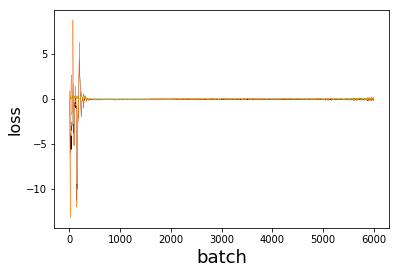

In [13]:
fig = plt.figure()
plt.plot([x[0] for x in gan.critic_valid_losses], color='black', linewidth=0.25)

plt.plot([x[1] for x in gan.critic_valid_losses], color='green', linewidth=0.25)
plt.plot([x[0] for x in gan.critic_generated_losses], color='red', linewidth=0.25)
plt.plot(gan.generator_losses, color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('loss', fontsize=16)

# plt.xlim(0, 2000)
# plt.ylim(0, 2)

plt.show()

In [14]:
def compare_images(img1, img2):
    return np.mean(np.abs(img1 - img2))

In [15]:

r, c = 5, 5

idx = np.random.randint(0, x_train.shape[0], BATCH_SIZE)
true_imgs = (x_train[idx] + 1) *0.5

fig, axs = plt.subplots(r, c, figsize=(15,15))
cnt = 0

for i in range(r):
    for j in range(c):
        axs[i,j].imshow(true_imgs[cnt], cmap = 'gray_r')
        axs[i,j].axis('off')
        cnt += 1
fig.savefig(os.path.join(RUN_FOLDER, "images/real.png"))
plt.close()

In [16]:
r, c = 5, 5
noise = np.random.normal(0, 1, (r * c, gan.latent_dim))
gen_imgs = gan.generator_model.predict(noise)

#Rescale images 0 - 1

gen_imgs = 0.5 * (gen_imgs + 1)
# gen_imgs = np.clip(gen_imgs, 0, 1)

fig, axs = plt.subplots(r, c, figsize=(15,15))
cnt = 0

for i in range(r):
    for j in range(c):
        axs[i,j].imshow(np.squeeze(gen_imgs[cnt, :,:,:]), cmap = 'gray_r')
        axs[i,j].axis('off')
        cnt += 1
fig.savefig(os.path.join(RUN_FOLDER, "images/sample.png"))
plt.close()


fig, axs = plt.subplots(r, c, figsize=(15,15))
cnt = 0

for i in range(r):
    for j in range(c):
        c_diff = 99999
        c_img = None
        for k_idx, k in enumerate((x_train + 1) * 0.5):
            
            diff = compare_images(gen_imgs[cnt, :,:,:], k)
            if diff < c_diff:
                c_img = np.copy(k)
                c_diff = diff
        axs[i,j].imshow(c_img, cmap = 'gray_r')
        axs[i,j].axis('off')
        cnt += 1

fig.savefig(os.path.join(RUN_FOLDER, "images/sample_closest.png"))
plt.close()